In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load your data
df = pd.read_csv("playground-series-s5e6/train.csv")  # Replace with your actual file path

# Separate features and target
X = df.drop(columns=['id', 'Fertilizer Name'])
y = df['Fertilizer Name']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [3]:
def add_ratio_features(df):
    df = df.copy()
    df['N_to_P'] = df['Nitrogen'] / (df['Phosphorous'] + 1)
    df['K_to_N'] = df['Potassium'] / (df['Nitrogen'] + 1)
    return df

def add_interaction_features(df):
    df = df.copy()
    df['Soil_Moisture'] = df['Soil Type'] + '_' + pd.cut(df['Moisture'], bins=3, labels=["Low", "Med", "High"]).astype(str)
    df['Crop_Temp'] = df['Crop Type'] + '_' + pd.cut(df['Temparature'], bins=3, labels=["Low", "Med", "High"]).astype(str)
    return df

def add_binary_flags(df):
    df = df.copy()
    df['HighMoisture'] = (df['Moisture'] > df['Moisture'].median()).astype(int)
    df['HighHumidity'] = (df['Humidity'] > df['Humidity'].median()).astype(int)
    return df

def add_npk_features(df):
    df = df.copy()
    N = df['Nitrogen']
    P = df['Phosphorous']
    K = df['Potassium']
    
    total_npk = N + P + K + 1e-5  # avoid divide by zero
    
    df['N_to_P'] = N / (P + 1)
    df['K_to_N'] = K / (N + 1)
    df['NPK_sum'] = total_npk
    df['NPK_std'] = np.std(np.stack([N, P, K]), axis=0)
    
    df['N_frac'] = N / total_npk
    df['P_frac'] = P / total_npk
    df['K_frac'] = K / total_npk

    return df


In [4]:
def evaluate_features(feature_funcs, base_df):
    df = base_df.copy()
    for func in feature_funcs:
        df = func(df)

    # Handle categorical
    cat_features = df.select_dtypes(include='object').columns.tolist()
    num_features = df.select_dtypes(include=np.number).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ],
        remainder='passthrough'
    )

    model = Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, df, y_encoded, cv=cv, scoring='accuracy')
    return scores.mean()


In [5]:
base_score = evaluate_features([], X)
print(f'Baseline (no engineered features): {base_score:.4f}')

score_npk = evaluate_features([add_npk_features], X)
print(f'With NPK-derived Features: {score_npk:.4f}')

c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

Baseline (no engineered features): 0.1993


c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Brad\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

With NPK-derived Features: 0.1924


In [13]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Label encode target variable
le_y = LabelEncoder()
y = le_y.fit_transform(df['Fertilizer Name'])

# Copy data
X = df.drop('Fertilizer Name', axis=1).copy()

# Encode categorical features
for col in ['Soil Type', 'Crop Type']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Now split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le_y.classes_),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=7, ...)

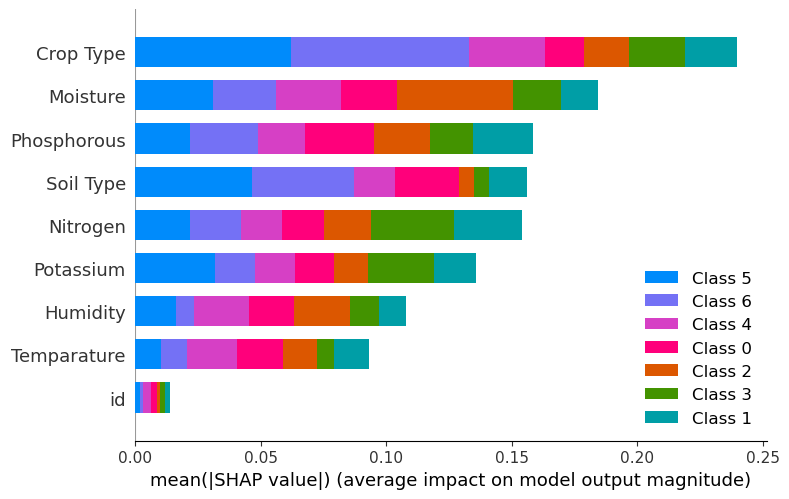

In [14]:
import shap

# Explainer for XGBoost (tree-based)
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_val)

# Summary plot
shap.summary_plot(shap_values, X_val, show=False)

In [15]:
shap.plots.bar(shap_values, max_display=20)


IndexError: list index out of range